<h1 align="center">Introduction to Machine Learning - Course Code: 25737</h1>
<h4 align="center">Instructor: Dr. Amiri</h4>
<h4 align="center">Sharif University of Technology, Spring 2024</h4>
<h4 align="center">Computer Assignment 3</h4>
<h4 align="center">

Question 3

</h4>

# Personal Data

In [9]:
# Set your student number
student_number = '99109111'
Name = 'Ali'
Last_Name = 'Yousefi'

# Autoencoders (25 Points)

In this problem, you should implement an autoencoder network, which generates an image presenting the next digit of the input digit. Here are some examples:

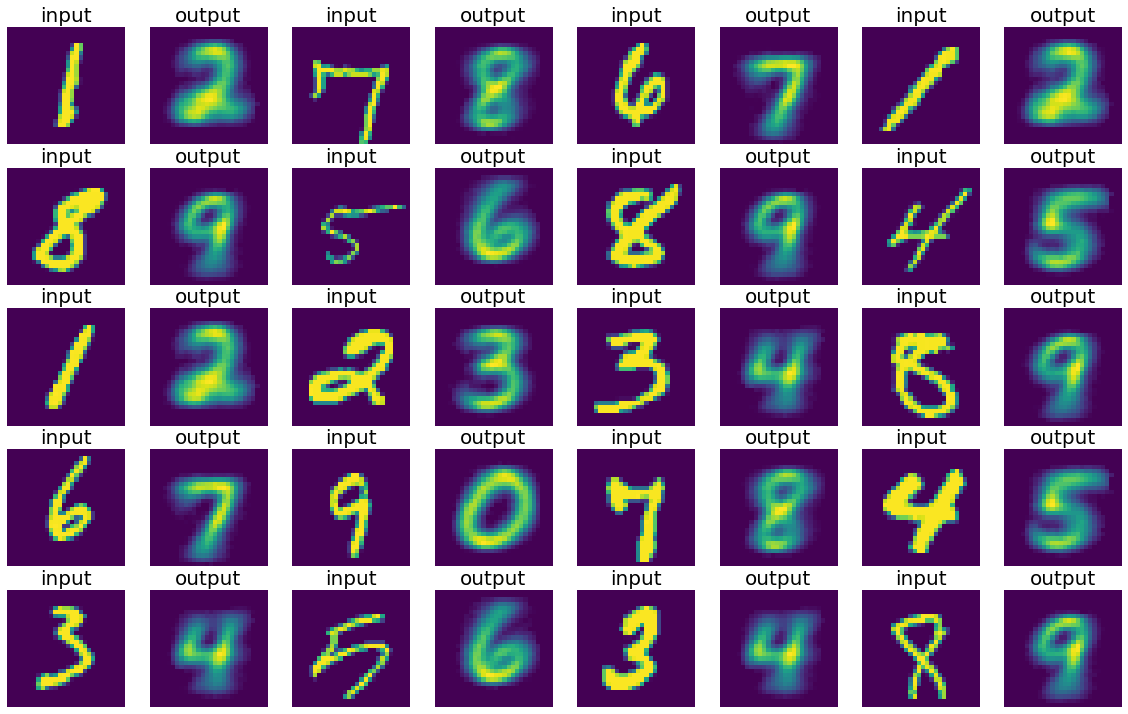

You should use the MNIST dataset, and the ground-truth for each example is provided by a helper function. Make sure to put the `ae_helper.py` file next to this notebook to use the helper function.

## Get the data

Get the data and split them into training, validation, and test sets, by running the following cell. `X` is the input images, `Y` is the ground-truth for each input, and `y` is the input's label.

In [10]:

from ae_helper import get_data
from sklearn.model_selection import train_test_split

X, Y, y = get_data()

X_train, X_test, Y_train, Y_test, y_train, y_test = train_test_split(X, Y, y, test_size=0.2, random_state=17)
X_train, X_val, Y_train, Y_val, y_train, y_val = train_test_split(X_train, Y_train, y_train, test_size=0.1, random_state=17)
X_train = X_train[:, np.newaxis, :, :]  # Add channel dimension (num_samples, 1, 28, 28)
X_val = X_val[:, np.newaxis, :, :]  # Add channel dimension (num_samples, 1, 28, 28)

/usr/local/lib/python3.10/dist-packages/sklearn/datasets/_openml.py:968: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


## Design your model

Please Implement your autoencoder model below. You MUST implement your model using the `torch` package. The model should input a batch of images and output the generated images for the whole batch. Your model can be consist of fully connected layers (using linear layers), but using fully-convolutional models has extra points.

In [11]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torch.nn import functional as F

class AutoEncoder(nn.Module):
     def __init__(self):
         super(AutoEncoder,self).__init__()
         #self.encoder = nn.Sequential(
             #nn.Conv2d(1, 4, kernel_size=5),
             #nn.Dropout2d(p=0.1),
             #nn.ReLU(True),
             #nn.Conv2d(4, 8, kernel_size=5),
             #nn.Dropout2d(p=0.1),
             #nn.ReLU(True),
             #nn.Flatten(),
             #nn.Linear(3200, 10),
             #nn.Softmax(dim=1))
         #self.decoder = nn.Sequential(
          #   nn.Linear(10, 400),
           #  nn.ReLU(True),
            # nn.Unflatten(1, (1, 20, 20)),
            # nn.Dropout2d(p=0.1),
            # nn.ConvTranspose2d(1, 10, kernel_size=5),
            # nn.ReLU(True),
             #nn.Dropout2d(p=0.1),
             #nn.ConvTranspose2d(10, 1, kernel_size=5)
             #)

         self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, 3, stride=2, padding=1),  # 28x28 -> 14x14
            nn.ReLU(),
            nn.Conv2d(32, 64, 3, stride=2, padding=1),  # 14x14 -> 7x7
            nn.ReLU(),
            nn.Conv2d(64, 128, 7)  # 7x7 -> 1x1
        )

        # Decoder
         self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 64, 7, 1, 0),  # 1x1 -> 7x7
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, 4, 2, 1),  # 7x7 -> 14x14
            nn.ReLU(),
            nn.ConvTranspose2d(32, 1, 4, 2, 1),  # 14x14 -> 28x28
            nn.Sigmoid()
        )

     def forward(self, x):

         out_en = self.encoder(x)
         #out = self.softmax(out_en)
         out = self.decoder(out_en)
         return out, out_en

model = AutoEncoder()

## The dataset class, and the dataloaders

The following cells implement the dataset class and create the data loaders for training and validation sets. Feel free to modify the batch size for each data loader.

In [12]:
from typing import Tuple
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np

class MnistNextDigitDataset(Dataset):
    def __init__(self, X: np.ndarray, Y: np.ndarray, y: np.ndarray):
        self.X = torch.from_numpy(X)
        self.Y = torch.from_numpy(Y)
        self.y = torch.from_numpy(y)

    def __len__(self) -> int:
        return self.X.shape[0]

    def __getitem__(self, i: int) -> Tuple[torch.Tensor, ...]:
        return self.X[i], self.Y[i]

In [13]:
train_dataloader = DataLoader(
    MnistNextDigitDataset(X_train, Y_train, y_train),
    batch_size=512,
    shuffle=True
)
val_dataloader = DataLoader(
    MnistNextDigitDataset(X_val, Y_val, y_val),
    batch_size=512,
    shuffle=False
)

In [69]:
def train_autoencoder(model: nn.Module, optimizer: torch.optim.Optimizer, dataloader: DataLoader) -> float:
    model.train()
    epoch_loss = 0.0
    criterion = nn.MSELoss()
    for batch_idx, (data, c) in enumerate(dataloader):
        data = data.to(device)
        c1 = c.unsqueeze(1)
        optimizer.zero_grad()
        reconstructed, encoded = model(data)
        loss = criterion(reconstructed, c1)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

    epoch_loss /= len(dataloader)

    return epoch_loss


def eval_autoencoder(model: nn.Module, dataloader: DataLoader) -> float:
    model.eval()
    epoch_loss = 0.0
    criterion = nn.MSELoss()

    with torch.no_grad():
        for batch_idx, (data, c) in enumerate(dataloader):
            data = data.to(device)
            c1 = c.unsqueeze(1)
            reconstructed, encoded = model(data)
            loss = criterion(reconstructed, c1)
            epoch_loss += loss.item()

    epoch_loss /= len(dataloader)

    return epoch_loss

## Instantiate the model and optimizer

Instantiate your model and optimizer in the following cell. Feel free to choose the optimizer and its configurations such as learning rate, decay, etc.

In [23]:
# Instantiate your model and move it to the appropriate device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
ae = AutoEncoder().to(device=device)

optimizer = torch.optim.Adam(ae.parameters(), lr=0.001)

## Train your autoencoder

Write your training/validation loop in the following cell for an arbitrary number of epochs (until convergence is detected). Make sure to use proper and readable logging containing training and validation metrics for each epoch. Select and store the state dictionary of the best epoch model according to the metrics.

In [70]:
import time

num_epochs =50
best_val_loss = float('inf')
best_model_state = None

print(X_train.shape)  # Should be (num_samples, 1, 28, 28)
print(X_val.shape)   # Should be (num_samples, 1, 28, 28)
for epoch in range(num_epochs):
    start_time = time.time()

    train_loss = train_autoencoder(ae, optimizer, train_dataloader)
    val_loss = eval_autoencoder(ae, val_dataloader)

    epoch_time = time.time() - start_time

    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Time: {epoch_time:.2f}s")

    if val_loss < best_val_loss:
        best_val_loss1=best_val_loss
        best_val_loss = val_loss
        best_model_state = ae.state_dict()
            # Save the best model state
        torch.save(best_model_state, 'best_model.pth')

    # Early stopping condition (optional)
    if epoch > 10 and val_loss > 0.99 * best_val_loss1 :
        print(best_val_loss1)
        print(val_loss)
        print("Validation loss did not improved too much. Stopping training.")
        break



(50400, 1, 28, 28)
(5600, 1, 28, 28)
Epoch [1/50], Train Loss: 0.0638, Val Loss: 0.0603, Time: 57.02s
Epoch [2/50], Train Loss: 0.0579, Val Loss: 0.0565, Time: 56.95s
Epoch [3/50], Train Loss: 0.0559, Val Loss: 0.0556, Time: 59.23s
Epoch [4/50], Train Loss: 0.0553, Val Loss: 0.0553, Time: 56.93s
Epoch [5/50], Train Loss: 0.0551, Val Loss: 0.0551, Time: 57.42s
Epoch [6/50], Train Loss: 0.0549, Val Loss: 0.0550, Time: 62.49s
Epoch [7/50], Train Loss: 0.0548, Val Loss: 0.0549, Time: 57.61s
Epoch [8/50], Train Loss: 0.0547, Val Loss: 0.0549, Time: 56.95s
Epoch [9/50], Train Loss: 0.0546, Val Loss: 0.0549, Time: 57.48s
Epoch [10/50], Train Loss: 0.0545, Val Loss: 0.0547, Time: 57.00s
Epoch [11/50], Train Loss: 0.0544, Val Loss: 0.0548, Time: 57.20s
Epoch [12/50], Train Loss: 0.0544, Val Loss: 0.0547, Time: 57.48s
0.054748558523980057
0.05474518713625995
Validation loss did not improved too much. Stopping training.


## Load the state dictionary of the best epoch

Load the state dictionary of the best epoch model into the model object.

In [71]:
# Load the best model checkpoint
checkpoint = torch.load('best_model.pth')
ae.load_state_dict(checkpoint)


<All keys matched successfully>

## Visualize your model

Select 40 examples from the test set and visualize the input and output of the model for them (See the examples at the beginning of the notebook).

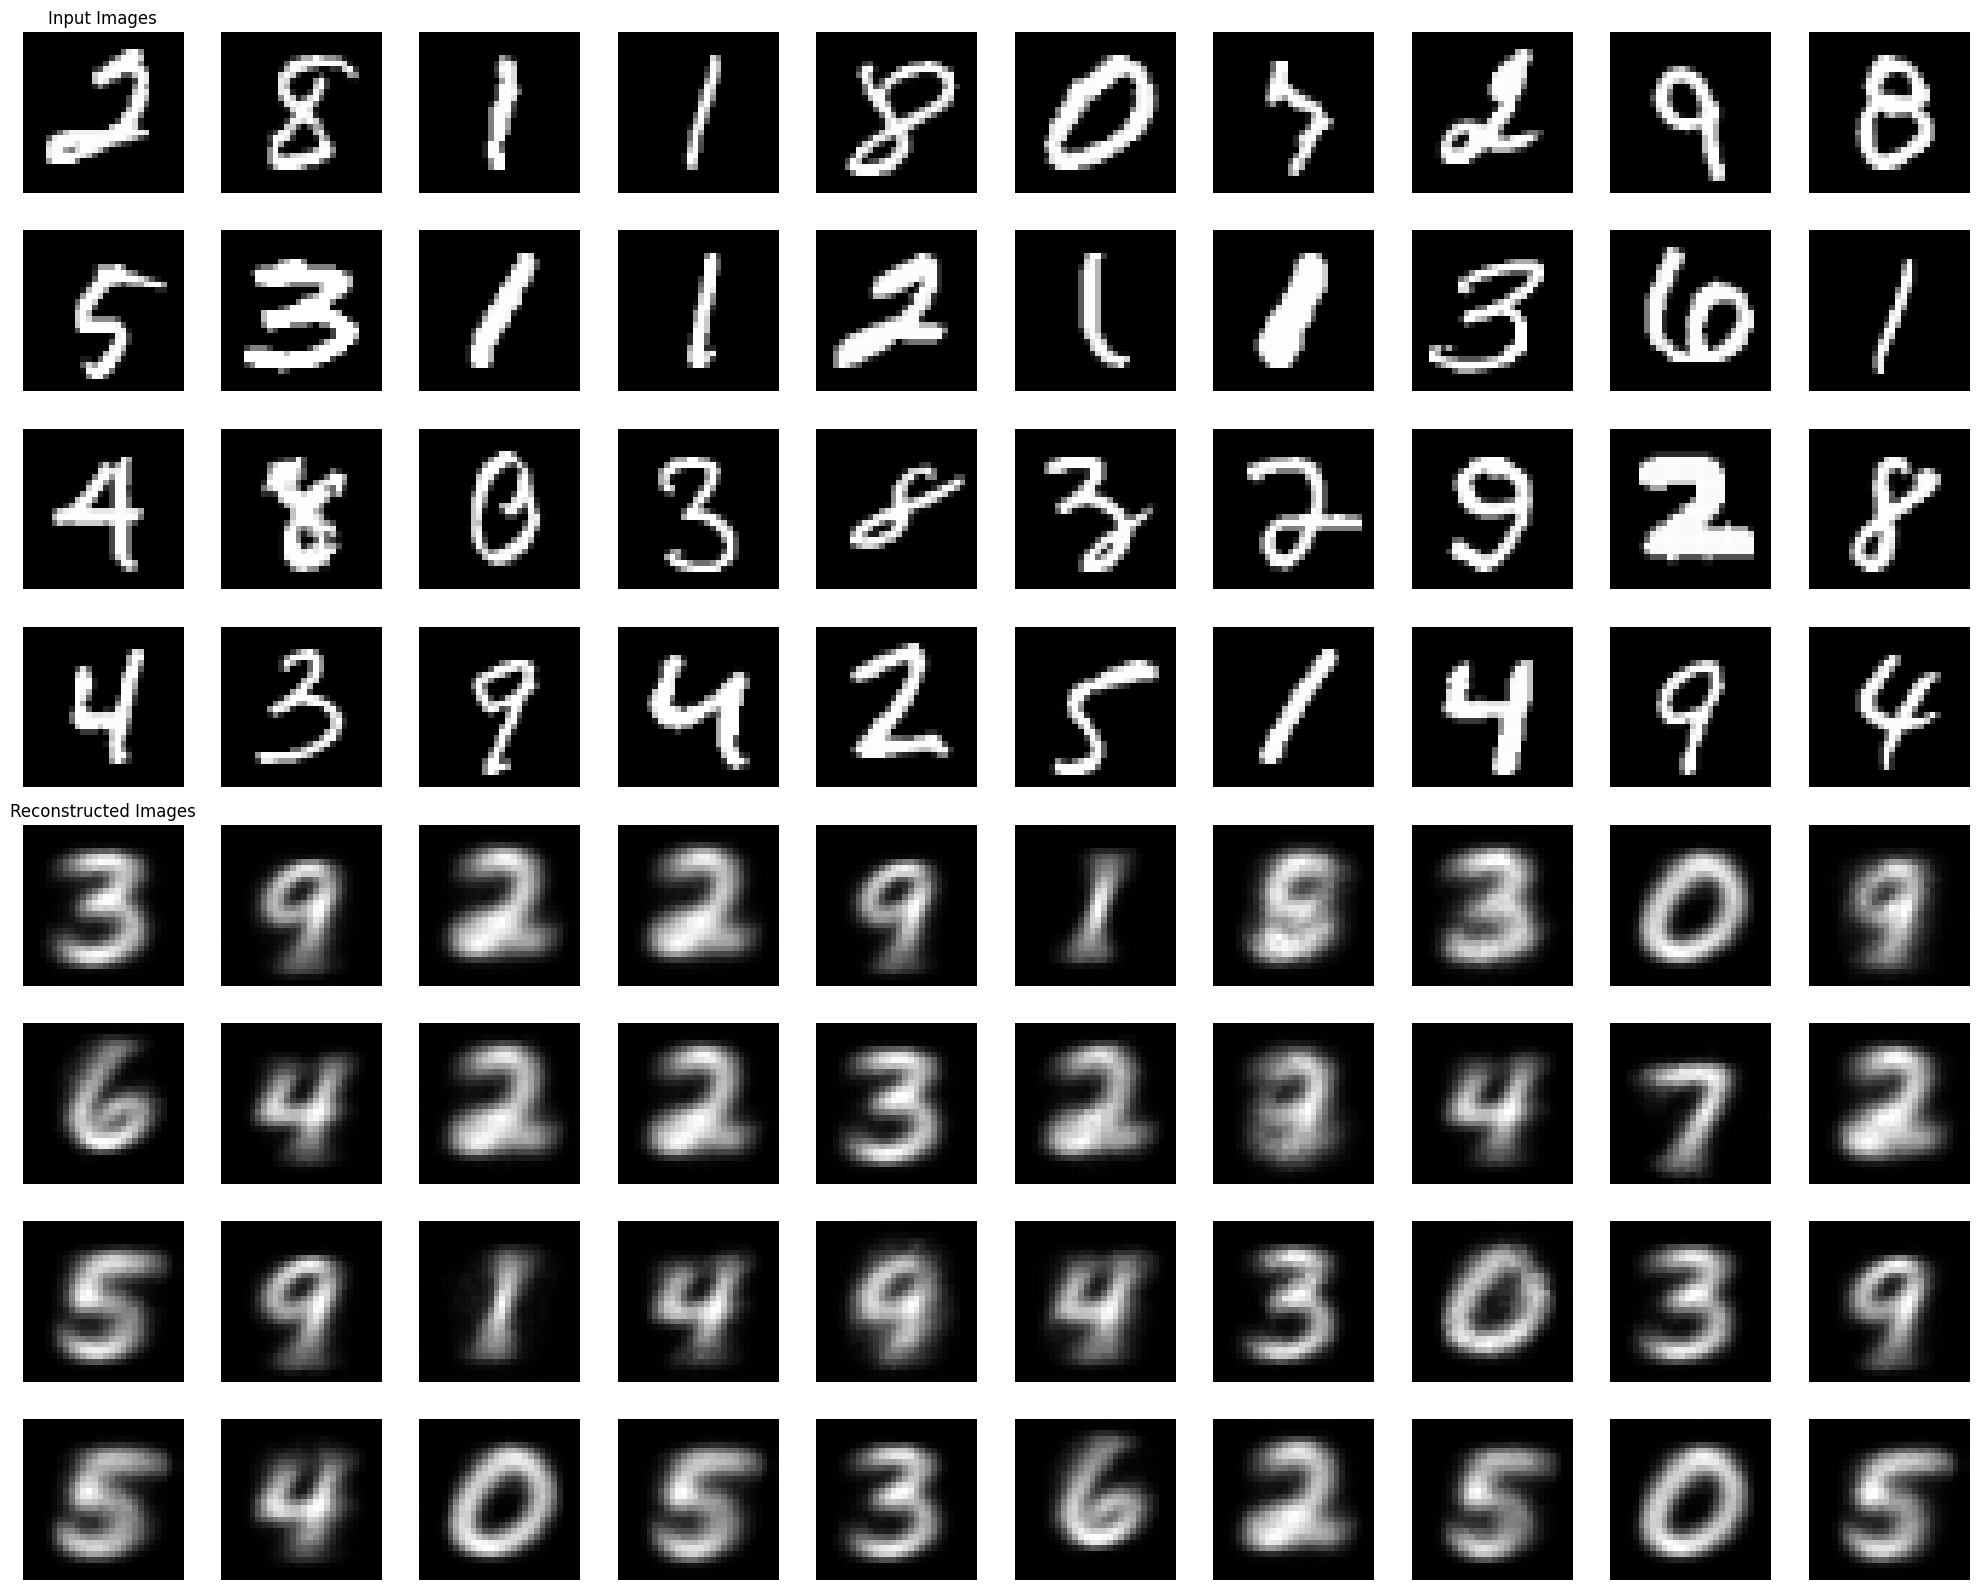

In [72]:
import matplotlib.pyplot as plt
import numpy as np

# Select 40 random examples from the test set
indices = np.random.choice(len(X_test), size=40, replace=False)
X_test_sample = X_test[indices]

# Reshape the input tensor to match the expected shape
X_test_sample = np.expand_dims(X_test_sample, axis=1)

# Pass the selected examples through the model
with torch.no_grad():
    X_test_sample_tensor = torch.from_numpy(X_test_sample).to(device)
    reconstructed, _ = ae(X_test_sample_tensor)

# Reshape the output tensor to 2D images
reconstructed = reconstructed.cpu().numpy()

# Create a figure with 8 rows and 10 columns
fig, axes = plt.subplots(8, 10, figsize=(20, 16))

# Iterate over the rows and columns
for i in range(4):
    for j in range(10):
        idx = i * 10 + j

        # Plot the input image
        axes[i, j].imshow(X_test_sample[idx, 0], cmap='gray')
        axes[i, j].axis('off')

        # Plot the reconstructed image
        axes[i + 4, j].imshow(reconstructed[idx, 0].squeeze(), cmap='gray')
        axes[i + 4, j].axis('off')

# Add titles
axes[0, 0].set_title('Input Images')
axes[4, 0].set_title('Reconstructed Images')

plt.tight_layout()
plt.show()